# Attention

## Attentionとは
連続したデータを扱う際に過去の重要なポイントに着目する(=Attention)ための手法

最終時刻の結果しか用いないより全部使った方がいい

実際LSTMも最終時刻だけより、全時刻の平均を用いる方が少し良いらしい

## Attentionを行う流れ

- これまでの隠れ層に対し、何らかの形でスコアリングする
- スコアをsoftmax関数にかけて正規化する
- 得られた重みについてそれぞれの隠れ層を加重平均する

# 文書分類にはどうやってAttentionを適用させたらいいの？

# 1.LSTM or GRU or RNN + Attention

[Hierarchical Attention Networks for Document Classification(Yang et.al,NAACL2016])](https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf)　<br>
を参考に実装

通常のLSTMから文書分類を行う場合は最終時刻の結果が用いられる。

Attentionを用いる場合は今までと同様、どの時刻の隠れ層に着目すべきかの加重和でcontext vectorを生成する。

しかし今回いままでと対応するDecoder側での$h_t$と対応するものって何...?


**$h_t$と対応するものはランダムに初期化した学習していく重み**


<img src='img/attention.png'>

### 1.スコアの計算
$i$は$0$〜$n$<br>
$W_s,b_s$は学習させる重み
### $$ u_i = tanh(W_sh_i + b_s) $$

$u_s$が前までのDecoder側での$h_t$の代わりで、学習する重み
### $$ score(u_i,u_s) = u^T_i u_s $$

### 2.softmaxで正規化
### $$α_i = \frac{exp(score(u_i,u_s) )}{\sum_{i'} exp(score(u_{i'},u_s) )}$$

### 3.加重和
### $$v =\sum_i α_ih_i$$

 ---
## 論文紹介
# Hierarchical Attention Networks for Document Classification(Yang et.al,NAACL2016])
https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf


文書分類（sentence classificationじゃない。複数文入った文書）についてAttentionを取り入れた

二つのレベルのAttention
- 単語レベルのAttention(これだけ使ってSentence Classificationしてもいい)
- 文書レベルのAttention

## Hierarchical Attention Networks(HAN)
<img src ='img/hierarchicl.png' width =600>

### 1.双方向のGRU+Attentionで１文ごとにEncode
### 2.Encodeされた文の順番でもう一度双方向GRU+Attention

### Attentionの可視化
<img src='img/attentionvisual.png'>

## Sentence Classification

In [1]:
from keras.preprocessing import sequence
from keras.models import Model
from keras.layers import Dense, Embedding,Input,Bidirectional,TimeDistributed,Activation,Lambda,Multiply,Dropout
from keras.layers import LSTM,GRU
import keras.backend as K
from keras.optimizers import Adam
from keras.datasets import imdb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend.
/Users/tomoki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
# HyperParams
max_features = 20000   #学習に用いる単語数
maxlen = 80  #学習に用いる最大長(これ以上は省略する)
batch_size = 32

In [3]:
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
25000 train sequences
25000 test sequences


### Zero Padding

In [4]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


### モデルの構築

In [5]:
hid_dim = 64  #隠れ層の次元数
embed_size = 128 #単語の埋め込み次元数
att_dim = 32  # attentionの計算のための全結合層における出力の次元
drop =0.5 #Dropout
out_size=1 # 最終出力数

In [6]:
inputs =Input(shape=(maxlen,))
emb= Embedding(max_features, embed_size)(inputs)  #Embedding層

state = Bidirectional(GRU(hid_dim, return_sequences=True))(emb)  #GRUかLSTM

#-------  Word Attention  ----
u_it = TimeDistributed(Dense(att_dim, activation='tanh'),name='T1')(state)
score = TimeDistributed(Dense(1),name='T2')(u_it)
score_ = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], maxlen)))(score)
alpha=Activation('softmax')(score_)
alpha_ = Lambda(lambda x: K.expand_dims(x))(alpha)

alphahs=Multiply(name='attention_mul')([alpha_,state])
s = Lambda(lambda x: K.sum(x, axis=1))(alphahs)
#-----------------------------------

dropout = Dropout(drop)(s)
output = Dense(units=out_size, activation='sigmoid')(dropout)

model = Model(inputs, output)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 80)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 80, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 80, 128)      74112       embedding_1[0][0]                
__________________________________________________________________________________________________
T1 (TimeDistributed)            (None, 80, 32)       4128        bidirectional_1[0][0]            
__________________________________________________________________________________________________
T2 (TimeDi

In [7]:
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
epochs = 2
batch_size = 32

In [9]:

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(x_test,y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 99s 4ms/step - loss: 0.5259 - acc: 0.7286 - val_loss: 0.3774 - val_acc: 0.8299
Epoch 2/2
25000/25000 [==============================] - 91s 4ms/step - loss: 0.2940 - acc: 0.8801 - val_loss: 0.3529 - val_acc: 0.8454


## Attentionの可視化

In [10]:
INDEX_FROM=3   

word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}

In [11]:
num=12
orig_sen = [id_to_word[id] for id in x_test[num]]
print('元文章')
print(' '.join(orig_sen))
print('正解ラベル')
print(y_test[num])

元文章
mildly gory moments but nothing worth the effort of watching the film i wouldn't say in fact aside from the above mentioned cameos this entire movie is really quite stale and turgid with characters that couldn't get <UNK> quick enough for my liking and an unfortunate lack of any real interest i didn't even find it fun in a laughable bad movie sense which is rare for me since i love a lot of pretty crummy films i'd say avoid
正解ラベル
0


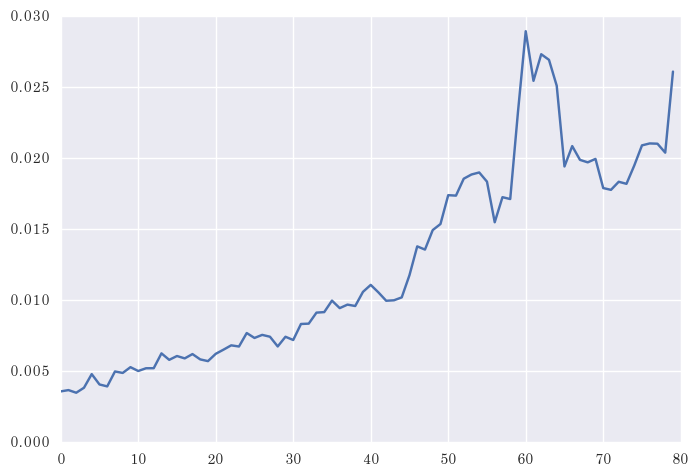

In [15]:
# attention weight
get_Attention = K.function([model.layers[0].input],
                                  [model.layers[6].output])
attention = get_Attention([x_test[num:num+1]])[0][0]
attention.shape

plt.plot(attention)
plt.show()

In [16]:
# attention　weightの合計が１の確
np.sum(attention)

1.0

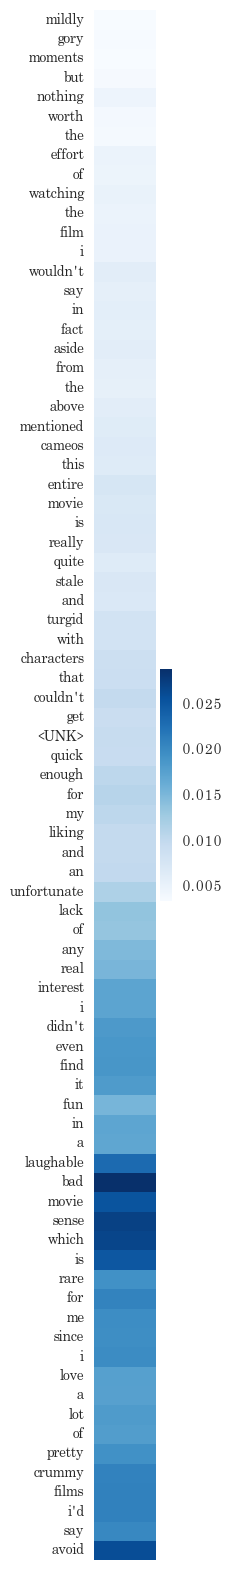

In [17]:
plt.figure(figsize=(1, 20))
sns.set(font='AppleMyungjo')
sns.heatmap(attention[:,np.newaxis],cmap="Blues",xticklabels=False,yticklabels=orig_sen)
plt.show()